### Specs to change depending on which map you're plotting (Khandwa/Khargone or Shivpuri)
#### In below box enter "KH" for Khandwa and Khargone and "SH" for Shivpuri

In [1]:
code = "KH"
if code == "KH":
    district_names = ["Khandwa", "Khargone"]
    district_name_a = "KHANDWA"
    district_name_b = "KHARGONE"
elif code == "SH":
    district_names = ["Shivpuri"]
    district_name_a = "SHIVPURI"
    district_name_b = "NOTHING"
else:
    print("Invalid code")
    
#Postprocessing stage
stage = "FINAL"

### Code to run to set up and plot map

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
from mapsplotlib import mapsplot as mplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
import sklearn.preprocessing
from math import isnan

from ipywidgets.embed import embed_minimal_html
import gmaps
import gmaps.geojson_geometries
import json

import random
#Load API key
gmaps.configure(api_key="API_KEY")

#Load district GeoJSON file from github for plotting later
JSON_file = "../../../Data/git_shape_files/district/india_district_med.json"

with open(JSON_file) as f:
    district_geometry = json.load(f)


In [4]:
'''Extract the parts of the geoJSON districts shapefile that correspond to the district(s) being plotted
'''
indices_to_extract = []
for index, dict_item in enumerate(district_geometry['features']):
    district_select = False
    for district_name in district_names:
        for elem in list(dict_item['properties'].values()):
            if (isinstance(elem, str)) and (district_name in elem):
                district_select = True
    if district_select == True:
        indices_to_extract.append(index)
        
list_of_features_dicts = list(np.asarray(district_geometry['features'])[indices_to_extract])
new_district_geometry_dict = {"type": "FeatureCollection", "features":list_of_features_dicts}


In [5]:
#Load original dataset to extract block names
file = "../../../Data/MP_Final_Predictions_with_GPS_coordinates.xlsx"
df = pd.read_excel(file)
display(df.head())

,District,Block,Village,VillageCode,OOSCpredicted,CumulativeOOSGforBlockpredi,GPS_lat,GPS_long,GPS_imputed
0,ANUPPUR,ANUPPUR,DOLA,234701038,93.706146,0.034075,23.177483,82.011841,1
1,ANUPPUR,ANUPPUR,PASAN,234701021,78.896919,0.062765,23.179165,81.887413,1
2,ANUPPUR,ANUPPUR,DUMAR KACHAR,234701086,61.786274,0.085233,23.175488,82.011696,1
3,ANUPPUR,ANUPPUR,PADOUR,234701056,60.417892,0.107203,23.098524,81.889786,0
4,ANUPPUR,ANUPPUR,REULA,234701023,55.643139,0.127437,23.256454,81.961205,0


In [6]:
file = "../../Excel_results/Renumbered/Final_clusters.xlsx"
cluster_results = pd.read_excel(file)
display(cluster_results.head())

,District,Block,Village,VillageCode,GPS_lat,GPS_long,OOSCpredicted,cluster_id
0,KHANDWA,BALADI,KUKSHI RAIYAT,232901059,22.191404,76.733887,44.723354,2
1,KHANDWA,BALADI,PAMAKHEDI,232901078,22.336861,76.606087,34.821598,3
2,KHANDWA,BALADI,MALUD,232901065,22.173595,76.715637,33.614811,1
3,KHANDWA,BALADI,JUNAPANI,232901043,22.227558,76.751854,21.881039,2
4,KHANDWA,BALADI,DANWANI MAPHI,232901029,22.203045,76.712883,21.831463,1


### Extract district

### Formatting data to work in the gmaps package

In [7]:
'''Creates dictionary with key = cluster ID and values = dataframe corresponding to the villages with that ID
'''
df_dict = {}
dict_keys = cluster_results.cluster_id.unique()
for dict_key in dict_keys:
    if dict_key != 0:
        cluster_subset = cluster_results[cluster_results.cluster_id == dict_key]
        df_dict[dict_key] = pd.DataFrame({"District": cluster_subset.District.values,"Block":cluster_subset.Block.values,"Total_OOSCpredicted":cluster_subset.OOSCpredicted.values, "coords":list(zip(cluster_subset["GPS_lat"], cluster_subset["GPS_long"]))})

In [8]:
#Drop the 0th cluster from the dictionary
dict_clusters = {key: value.coords.values for key, value in df_dict.items() if key != 0}

In [9]:
#Determine the district that the majority of elements in a cluster belong to
from collections import Counter
all_districts_dict = {}
for key, value in df_dict.items():
    cluster_district_list = value.District.values
    district_count = Counter(cluster_district_list)
    most_common_district = district_count.most_common(1)[0][0]
    all_districts_dict[key] = most_common_district

unique_dominant_district = list(set(list(all_districts_dict.values())))

In [10]:
#Extract the clusters corresponding to the districts we want to plot
clusters_in_district = district_dict =[k for k, v in all_districts_dict.items() if (v == district_name_a) or (v == district_name_b)]
district_dict = {key: df_dict[key] for key in clusters_in_district}

### Generate cluster colors so that clusters in the same block are the same color

In [11]:
#Determinant block that majority of villages in a cluster belongs to
from collections import Counter
block_dict = {}
for key, value in district_dict.items():
    cluster_block_list = value.Block.values
    blocks_count = Counter(cluster_block_list)
    most_common_block = blocks_count.most_common(1)[0][0]
    block_dict[key] = most_common_block

unique_dominant_blocks = list(set(list(block_dict.values())))

In [12]:
#Generating list of unique cluster colors as hexs (rgba function is broken in gmaps) for each block
NUM_COLORS = len(unique_dominant_blocks)
print(NUM_COLORS)

if district_name_a == "SHIVPURI":
    cm = pylab.get_cmap('tab10')
    colors = []
    for i in range(NUM_COLORS):
        rgb = cm(1.*i/NUM_COLORS)[:3]  # color will now be an RGBA tuple
        colors.append(matplotlib.colors.rgb2hex(rgb))
        random.shuffle(colors)
else:
    colors = ["#800000", "#9A6324", "#808000", "#469990", "#000075", "#e6194B", "#f58231", "#ffe119", "#bfef45", "#3cb44b", "#42d4f4", "#4363d8", "#911eb4", "#f032e6"]
    random.shuffle(colors)

#Create dictionary that maps a block name to a color
block_color_dict = dict(zip(unique_dominant_blocks, colors))

14


### Extract the convex hull of each cluster and assign it a color

In [13]:
from scipy.spatial import ConvexHull

In [14]:
#This dictionary only contains convex hulls for clusters that are real clusters
hull_dict = {}
ordered_colors = []
for key, value in district_dict.items():
    #Just turn list of tuples into an array of lists
    coords = np.asarray([list(elem) for elem in value.coords.values])
    hull = ConvexHull(coords)
    hull_points = [tuple(elem) for elem in coords[hull.vertices]]
    hull_dict[key] = hull_points
    
    #Create a list of the dominant blocks in the same order as the hull_dict
    dominant_block = block_dict[key]
    ordered_colors.append(block_color_dict[dominant_block])


### Extract coordinates of the villages in the districts we're plotitng and generate size of markers proportional to OOSC

In [15]:
cluster_results = cluster_results[(cluster_results.District == district_name_a) | (cluster_results.District == district_name_b)]
cluster_results = cluster_results.reset_index(drop = True)

In [16]:
#Extract zipped coordinate list of villages
all_coords = list(zip(cluster_results["GPS_lat"], cluster_results["GPS_long"]))

#Generate a scaled column of sizes between 0 and 10 for scatter plot (based on OOSC column)
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(1, 10))
column = cluster_results[["OOSCpredicted"]]
scaled_sizes = scaler.fit_transform(column)

#Make datatype correct for scale attribute of gmaps.symbol_layer plotting
scaled_sizes = scaled_sizes.tolist()
scaled_sizes = [int(round(item)) for sublist in scaled_sizes for item in sublist]

In [17]:
#Divide points by whether they are in a cluster or not so that points not in a cluster but within a polygon show up differently
from operator import itemgetter

all_coords_array = np.asarray(all_coords)
indices_real = cluster_results.index[cluster_results['cluster_id'] != 0].tolist()
real_coords = list(itemgetter(*indices_real)(all_coords))
real_sizes = list(itemgetter(*indices_real)(scaled_sizes))
block_real = list(cluster_results.loc[indices_real].Block.values)
village_real = list(cluster_results.loc[indices_real].Village.values)
cluster_real = [str(cluster_val) if cluster_val != 0 else 'No cluster' for cluster_val in cluster_results.loc[indices_real].cluster_id.values]
names_real = [{"block_name": a, "village_name": b, "cluster_name": c} for a, b, c in zip(block_real, village_real, cluster_real)]

indices_fake = cluster_results.index[cluster_results['cluster_id'] == 0].tolist()
fake_coords = list(itemgetter(*indices_fake)(all_coords))
fake_sizes = list(itemgetter(*indices_fake)(scaled_sizes))
block_fake = list(cluster_results.loc[indices_fake].Block.values)
village_fake = list(cluster_results.loc[indices_fake].Village.values)
cluster_fake = [str(cluster_val) if cluster_val != 0 else 'No cluster' for cluster_val in cluster_results.loc[indices_fake].cluster_id.values]
names_fake = [{"block_name": a, "village_name": b, "cluster_name": c} for a, b, c in zip(block_fake, village_fake, cluster_fake)]

In [18]:
#Generate text for clickable boxes on each marker

info_box_template = """
<dl>
<dt>Block name</dt><dd>{block_name}</dd>
<dt>Village name</dt><dd>{village_name}</dd>
<dt>Cluster ID</dt><dd>{cluster_name}</dd>
</dl>
"""

real_info = [info_box_template.format(**elem) for elem in names_real]
fake_info = [info_box_template.format(**elem) for elem in names_fake]


### Combine scatter plot and polygons

In [19]:
#Basemap
if district_name_a == "SHIVPURI":
    center_coords = (25.432173, 77.610619)
else:
    center_coords = (21.841487, 75.970118)
fig = gmaps.figure(center = center_coords, zoom_level = 10, map_type = 'TERRAIN')

#Create districts layer    
districts_layer = gmaps.geojson_layer(new_district_geometry_dict, fill_opacity = 0)

#Create scatter layer
scatter_layer_real = gmaps.symbol_layer(real_coords, stroke_color="#204060", scale = real_sizes, info_box_content = real_info, display_info_box = True)
scatter_layer_fake = gmaps.symbol_layer(fake_coords, fill_color="#a2b2b3", stroke_color="#9900ff", scale = fake_sizes, fill_opacity = 1, info_box_content = fake_info, display_info_box = True)


#Createthe polygon layer
#Creating dictionary where each key is a cluster name and each value is the polygon object for that cluster
cluster_layers = {}
for counter, (key, value) in enumerate(hull_dict.items()):
    cluster_layers["{}".format(key)] = gmaps.Polygon(value, stroke_color= ordered_colors[counter], fill_color=ordered_colors[counter])

'''Turn the values of the the dictionary into a list of the cluster polygon objects and pass 
it to the drawing layer feature to add cluster polygons to map'''
drawing = gmaps.drawing_layer(features=list(cluster_layers.values()), show_controls=False)
    
#Display all layers in figure
fig.add_layer(districts_layer)
fig.add_layer(scatter_layer_real)
fig.add_layer(scatter_layer_fake)
fig.add_layer(drawing)
fig

#Export as HTML
embed_minimal_html('../html_files/{}_cluster_map_{}.html'.format(stage,code), views=[fig])

14


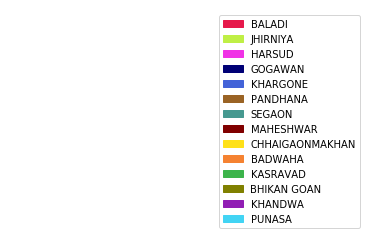

In [20]:
#Create color legend for the above plot
plt.axis('off')

patchList = []
for key in block_color_dict:
        data_key = mpatches.Patch(color=block_color_dict[key], label=key)
        patchList.append(data_key)

plt.legend(handles=patchList)
plt.savefig("../legends/{}_Legend_{}.png".format(stage,code), bbox_inches='tight')

#Number of blocks
print(len(block_color_dict.values()))